# **SSCS - Training**

Developed by André Paiva

Based on SSCS Dataset created by Helena Cuesta and Emilia Gómez

## 1 - Initialization

In [1]:
import os
import hdf5plugin
import h5py
import json
import time
import zipfile
import tables
import requests
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, Reduction
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.layers import Input, Resizing, Conv2D, BatchNormalization, Multiply
from keras import backend as K
import sscs

2023-06-25 19:12:28.523330: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7630] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-06-25 19:12:28.523404: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-06-25 19:12:28.523422: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1500] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-25 19:12:28.536401: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-25 19:12:32,453	INFO worker.py:1636 -- Sta

In [2]:
sscs.initialize(save_model = False, load_model = True, training = False, evaluate = False)

## 2 - Download and extract dataset SSCS

In [3]:
sscs.download()

SSCS Dataset found.
SSCS Dataset already extracted.
Done.


## 3 - Training VoasCNN

In [4]:
ds_train = sscs.get_dataset(split='train', end_index=1000)

ds_val = sscs.get_dataset(split='validate', end_index=300)

ds_test = sscs.get_dataset(split='test', end_index=300)

2023-06-25 19:12:34.335127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:953] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-25 19:12:34.340771: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:953] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-25 19:12:34.340850: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:953] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-25 19:12:34.344742: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:953] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-25 19:12:34.344826: I tensorflow/compile

In [5]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

In [6]:
voas_cnn = sscs.res_voas_cnn_model()
voas_cnn.compile(optimizer=Adam(learning_rate=2e-3),
                 loss=BinaryCrossentropy(reduction=Reduction.SUM_OVER_BATCH_SIZE),
                 metrics=[f1])

#print(voas_cnn.summary())

sscs.load_weights(voas_cnn)
sscs.train(voas_cnn, ds_train, ds_val)       

## 4 - Playground

2023-06-25 19:12:40.422643: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:434] Loaded cuDNN version 8600
2023-06-25 19:12:41.558292: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 4s 4s/step


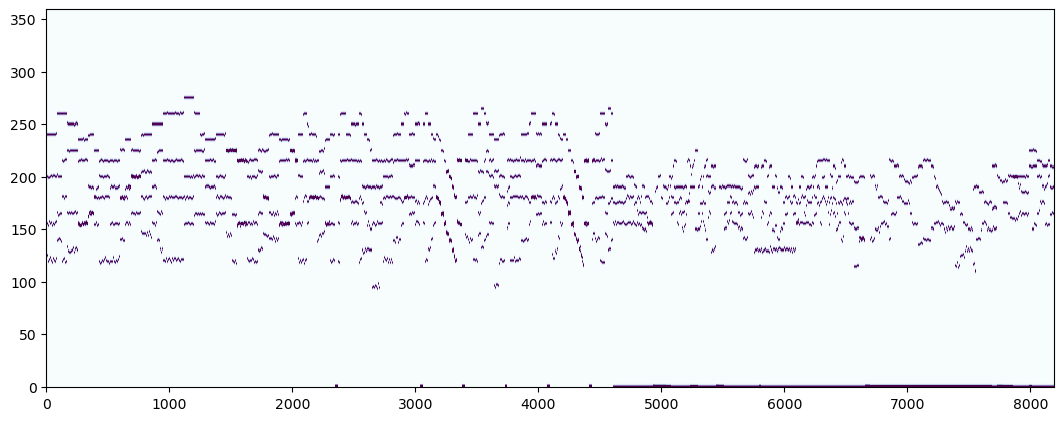

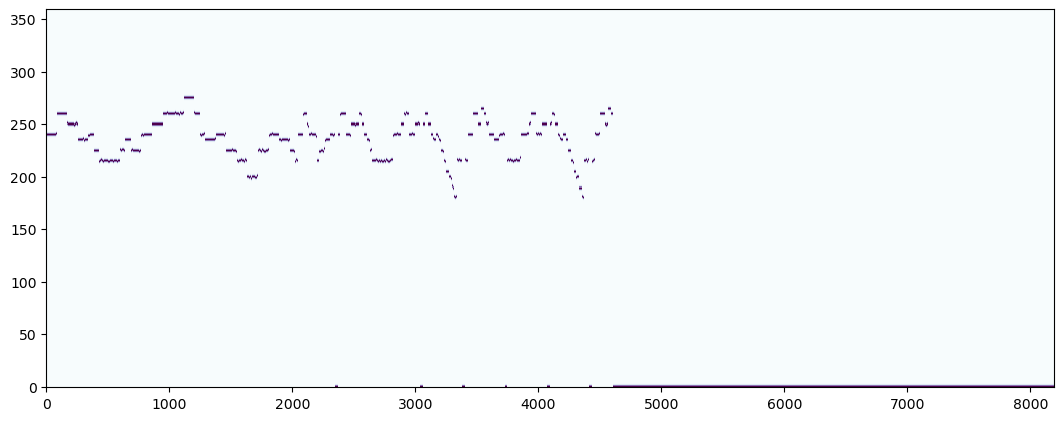

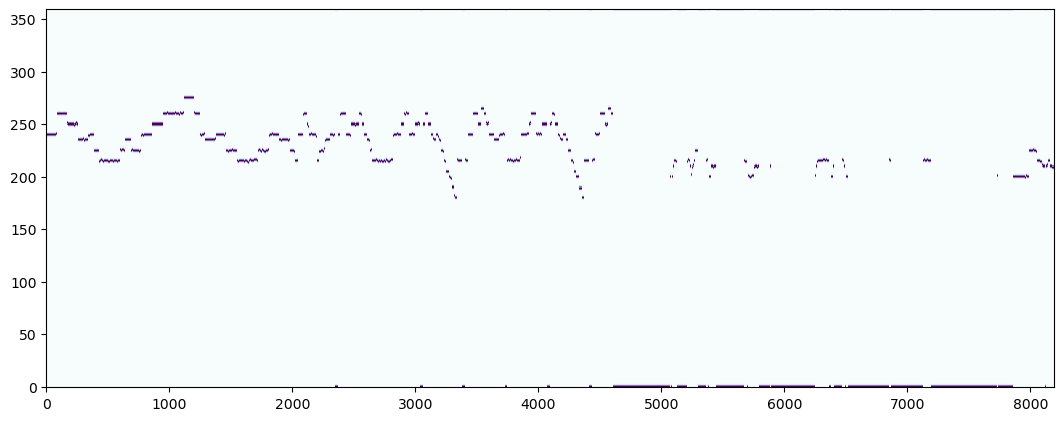

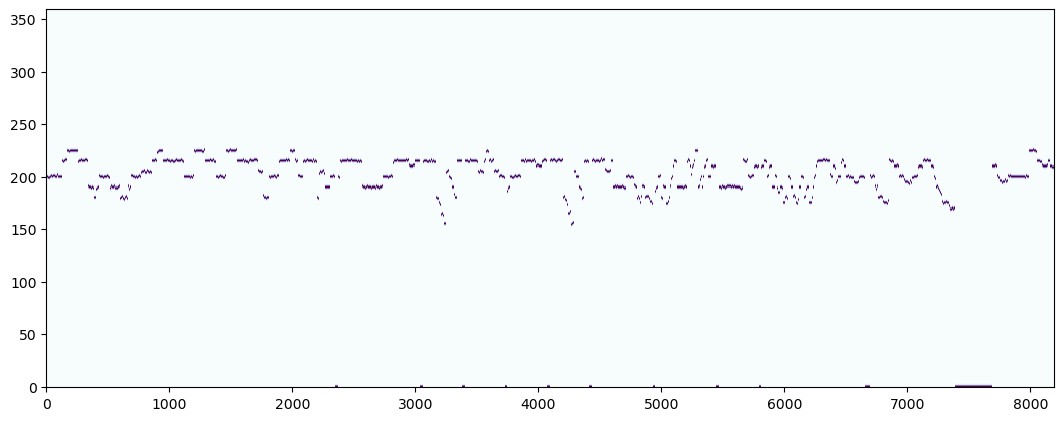

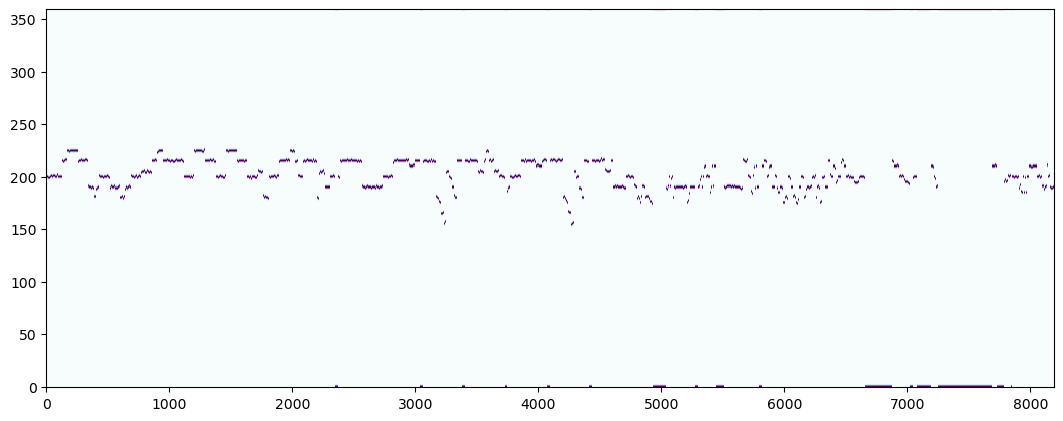

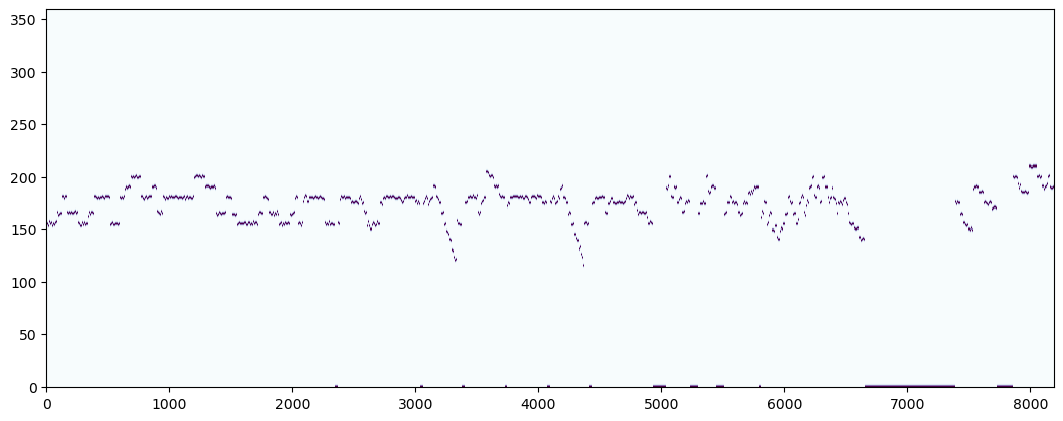

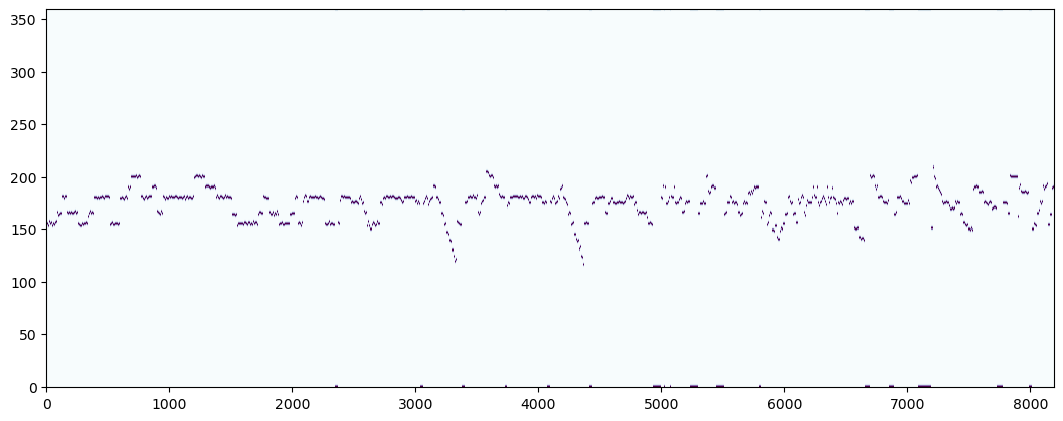

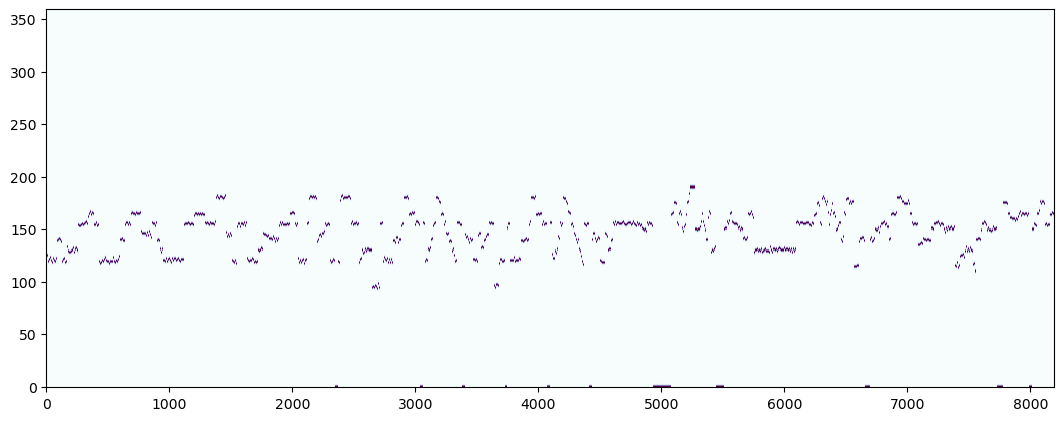

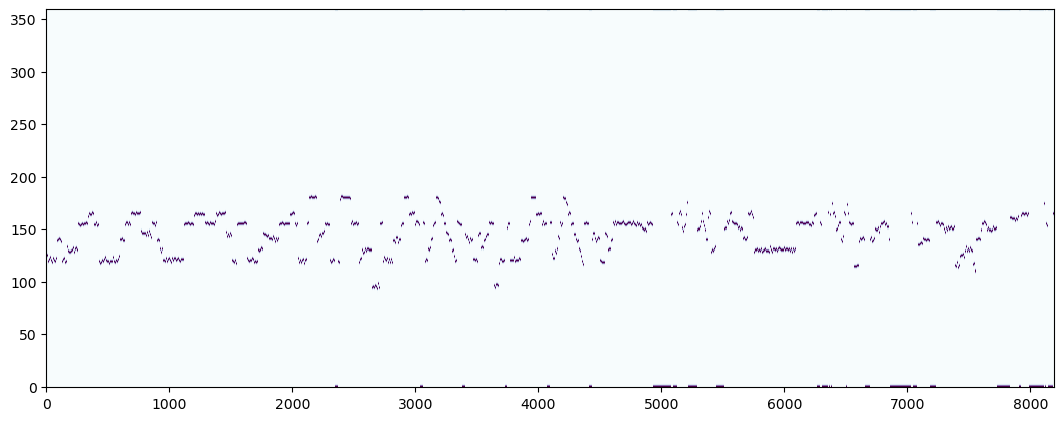

In [7]:
seq_test = sscs.get_sequence(split='test')
mix, satb = seq_test.__getitem__(np.random.randint(0, seq_test.__len__() - 1))

mix = mix.numpy()
s_pred, a_pred, t_pred, b_pred = voas_cnn.predict(mix)

mix = np.moveaxis(mix, 0, 1).reshape(360, -1)
s = np.moveaxis(satb[0].numpy(), 0, 1).reshape(360, -1)
a = np.moveaxis(satb[1].numpy(), 0, 1).reshape(360, -1)
t = np.moveaxis(satb[2].numpy(), 0, 1).reshape(360, -1)
b = np.moveaxis(satb[3].numpy(), 0, 1).reshape(360, -1)
s_pred = np.moveaxis(s_pred, 0, 1).reshape(360, -1)
a_pred = np.moveaxis(a_pred, 0, 1).reshape(360, -1)
t_pred = np.moveaxis(t_pred, 0, 1).reshape(360, -1)
b_pred = np.moveaxis(b_pred, 0, 1).reshape(360, -1)

s_argmax = np.argmax(s_pred, axis=0)
a_argmax = np.argmax(a_pred, axis=0)
t_argmax = np.argmax(t_pred, axis=0)
b_argmax = np.argmax(b_pred, axis=0)

s_thres = np.zeros((360, s_argmax.shape[0]))
a_thres = np.zeros((360, a_argmax.shape[0]))
t_thres = np.zeros((360, t_argmax.shape[0]))
b_thres = np.zeros((360, b_argmax.shape[0]))

for i in range(s_argmax.shape[0]):
    s_thres[s_argmax[i], i] = 1.0
    a_thres[a_argmax[i], i] = 1.0
    t_thres[t_argmax[i], i] = 1.0
    b_thres[b_argmax[i], i] = 1.0

s_filtered = np.array(gaussian_filter1d(s_thres, 1, axis=0, mode='wrap'))
a_filtered = np.array(gaussian_filter1d(a_thres, 1, axis=0, mode='wrap'))
t_filtered = np.array(gaussian_filter1d(t_thres, 1, axis=0, mode='wrap'))
b_filtered = np.array(gaussian_filter1d(b_thres, 1, axis=0, mode='wrap'))

s_pred_postproc = (s_filtered - np.min(s_filtered))/(np.max(s_filtered)-np.min(s_filtered))
a_pred_postproc = (a_filtered - np.min(a_filtered))/(np.max(a_filtered)-np.min(a_filtered))
t_pred_postproc = (t_filtered - np.min(t_filtered))/(np.max(t_filtered)-np.min(t_filtered))
b_pred_postproc = (b_filtered - np.min(b_filtered))/(np.max(b_filtered)-np.min(b_filtered))

idx = 10

sscs.plot(mix)
sscs.plot(s)
sscs.plot(s_pred_postproc)
#sscs.plot(s_pred)
sscs.plot(a)
sscs.plot(a_pred_postproc)
#sscs.plot(a_pred)
sscs.plot(t)
sscs.plot(t_pred_postproc)
#sscs.plot(t_pred)
sscs.plot(b)
sscs.plot(b_pred_postproc)
#sscs.plot(b_pred)

sscs.song_to_midi(s, a, t, b, './MIDI/original.mid')
sscs.song_to_midi(s_pred_postproc, a_pred_postproc, t_pred_postproc, b_pred_postproc,
                  './MIDI/predicted.mid')